In [1]:
import copy
import itertools as it
import random
import typing

from IPython.core.display import display, HTML
from nbmetalog import nbmetalog as nbm
import pandas as pd
import seaborn as sns
from tqdm import tqdm

import pylib

random.seed(1)


In [2]:
nbm.print_metadata()


context: ci
hostname: fv-az585-893
interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
nbcellexec: null
nbname: 01-doubling-incidence-reservation-surface
nbpath: /home/runner/work/hstrat-surface-concept/hstrat-surface-concept/binder/01-doubling-incidence-reservation-surface.ipynb
revision: null
session: b9e8c16b-3ebd-47eb-a73e-54951310c2fe
timestamp: 2024-03-24T00:20:00Z00:00


IPython==7.31.1
keyname==0.5.2
yaml==6.0
nbmetalog==0.2.6
pandas==1.5.2
seaborn==0.12.1
re==2.2.1
comm==0.1.3
logging==0.5.1.2
psutil==5.9.5
zmq==25.1.0
json==2.0.9
ipykernel==6.23.3


In [3]:
def get_num_sites_reserved_per_incidence_at_rank(rank: int) -> int:
    return pylib.bit_ceil(pylib.hanoi.get_max_hanoi_value_through_index(rank) + 1)


In [4]:
# test get_num_sites_reserved_per_incidence_at_rank
assert [get_num_sites_reserved_per_incidence_at_rank(rank) for rank in range(17)] == [
        # hanoi sequence (1-based):
    1,  # 1,
    2,  # 2,
    2,  # 1,
    4,  # 3,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    4,  # 4,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    4,  # 3,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    8,  # 5,
    8,  # 1,
]


In [5]:
def get_num_incidence_reservations_at_rank(rank: int, surface_size: int) -> int:
    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    assert surface_size % reservation_size == 0
    num_reservations = surface_size // reservation_size
    return num_reservations


In [6]:
# test get_num_incidence_reservations_at_rank
assert [get_num_incidence_reservations_at_rank(rank, 64) for rank in range(17)] == [
         # hanoi sequence (1-based):
    64,  # 1,
    32,  # 2,
    32,  # 1,
    16,  # 3,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    16,  # 4,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    16,  # 3,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    8,   # 5,
    8,   # 1,
]


In [7]:
def get_deposition_site_at_rank(rank: int, surface_size: int) -> int:
    num_incidence_reservations = get_num_incidence_reservations_at_rank(
        rank, surface_size
    )
    reservation_index = (
        pylib.hanoi.get_hanoi_value_incidence_at_index(rank)
        % num_incidence_reservations
    )

    longevity_ordered_reservation_position = (
        pylib.longevity_ordering_naive.get_longevity_mapped_position_of_index(
            reservation_index,
            num_incidence_reservations,
        )
    )

    within_reservation_offset = pylib.hanoi.get_hanoi_value_at_index(rank)

    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    assert within_reservation_offset < reservation_size
    return (
        longevity_ordered_reservation_position * reservation_size
        + within_reservation_offset
    )


In [8]:
# test get_deposition_site_at_rank
assert [get_deposition_site_at_rank(rank, 64) for rank in range(19)] == [
        # num_reservations
        #     # hanoi sequence (0-based):
    0,  # 64, # 0,
    1,  # 32, # 1,
    32, # 32, # 0,
    2,  # 16, # 2,
    16, # 16, # 0,
    33, # 16, # 1,
    48, # 16, # 0,
    3,  # 16, # 3,
    8,  # 16, # 0,
    17, # 16, # 1,
    24, # 16, # 0,
    34, # 16, # 2,
    40, # 16, # 0,
    49, # 16, # 1,
    56, # 16, # 0,
    4,  # 8,  # 4,
    0,  # 8,  # 0,
    9,  # 8,  # 1,
    32, # 8,  # 0,
]

assert [get_deposition_site_at_rank(rank, 16) for rank in range(21)] == [
        # num_reservations
        #     # hanoi sequence (0-based):
    0,  # 16, # 0,
    1,  # 8,  # 1,
    8,  # 8,  # 0,
    2,  # 4,  # 2,
    4,  # 4,  # 0,
    9,  # 4,  # 1,
    12, # 4,  # 0,
    3,  # 4,  # 3,
    0,  # 4,  # 0,
    5,  # 4,  # 1,
    8,  # 4,  # 0,
    10, # 4,  # 2,
    4,  # 4,  # 0,
    13, # 4,  # 1,
    12, # 4,  # 0,
    4,  # 2,  # 4,
    0,  # 2,  # 0,
    1,  # 2,  # 1,
    8,  # 2,  # 0,
    2,  # 2,  # 2,
    0,  # 2,  # 0,
]


In [9]:
def get_hanoi_value_of_site_at_rank(site: int, surface_size: int, rank: int) -> int:
    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    return site % reservation_size


In [10]:
# test get_hanoi_value_of_site
assert [get_hanoi_value_of_site_at_rank(site, 16, 0) for site in range(16)] == [0] * 16
assert [get_hanoi_value_of_site_at_rank(site, 16, 1) for site in range(16)] == [
    0,
    1,
] * 8
assert [get_hanoi_value_of_site_at_rank(site, 16, 2) for site in range(16)] == [
    0,
    1,
] * 8
assert [get_hanoi_value_of_site_at_rank(site, 16, 3) for site in range(16)] == [
    0,
    1,
    2,
    3,
] * 4
assert [get_hanoi_value_of_site_at_rank(site, 16, 4) for site in range(16)] == [
    0,
    1,
    2,
    3,
] * 4
assert [get_hanoi_value_of_site_at_rank(site, 16, 15) for site in range(16)] == [
    *range(8)
] * 2
assert [get_hanoi_value_of_site_at_rank(site, 16, 16) for site in range(16)] == [
    *range(8)
] * 2
assert [get_hanoi_value_of_site_at_rank(site, 16, 17) for site in range(16)] == [
    *range(8)
] * 2


In [11]:
def get_reservation_index_of_site_at_rank(
    site: int, surface_size: int, rank: int
) -> int:
    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    longevity_ordered_reservation_position = site // reservation_size

    num_incidence_reservations = get_num_incidence_reservations_at_rank(
        rank, surface_size
    )
    reservation_index = pylib.longevity_ordering_naive.get_longevity_index_of_mapped_position(
        longevity_ordered_reservation_position, num_incidence_reservations
    )
    return reservation_index


In [12]:
# test get_reservation_index_of_site_at_rank
assert [get_reservation_index_of_site_at_rank(site, 16, 0) for site in range(16)] == [
    0,
    8,
    4,
    9,
    2,
    10,
    5,
    11,
    1,
    12,
    6,
    13,
    3,
    14,
    7,
    15,
]
assert [get_reservation_index_of_site_at_rank(site, 16, 1) for site in range(16)] == [
    0,
    0,
    4,
    4,
    2,
    2,
    5,
    5,
    1,
    1,
    6,
    6,
    3,
    3,
    7,
    7,
]
assert [get_reservation_index_of_site_at_rank(site, 16, 2) for site in range(16)] == [
    0,
    0,
    4,
    4,
    2,
    2,
    5,
    5,
    1,
    1,
    6,
    6,
    3,
    3,
    7,
    7,
]
assert [get_reservation_index_of_site_at_rank(site, 16, 3) for site in range(16)] == [
    0,
    0,
    0,
    0,
    2,
    2,
    2,
    2,
    1,
    1,
    1,
    1,
    3,
    3,
    3,
    3,
]
assert [get_reservation_index_of_site_at_rank(site, 16, 4) for site in range(16)] == [
    0,
    0,
    0,
    0,
    2,
    2,
    2,
    2,
    1,
    1,
    1,
    1,
    3,
    3,
    3,
    3,
]
assert [get_reservation_index_of_site_at_rank(site, 16, 15) for site in range(16)] == [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
assert [get_reservation_index_of_site_at_rank(site, 16, 16) for site in range(16)] == [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]
assert [get_reservation_index_of_site_at_rank(site, 16, 17) for site in range(16)] == [
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
]


In [13]:
def get_hanoi_incidence_of_site_at_rank(site: int, surface_size: int, rank: int) -> int:
    # this method deals with incidence wraparound over number of reservations
    hanoi_value = get_hanoi_value_of_site_at_rank(site, surface_size, rank)
    incidence_count = pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
        hanoi_value,
        rank,
    )
    incidence_count = max(incidence_count, 1)
    max_incidence = incidence_count - 1

    num_incidence_reservations = get_num_incidence_reservations_at_rank(
        rank, surface_size
    )
    reservation_index = get_reservation_index_of_site_at_rank(site, surface_size, rank)

    if max_incidence >= num_incidence_reservations:
        excess_incidence = (
            max_incidence - reservation_index
        ) % num_incidence_reservations
        candidate_incidence = max_incidence - excess_incidence
        candidate_rank = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
            hanoi_value,
            candidate_incidence,
        )
        if candidate_rank == rank:
            return candidate_incidence
        else:
            return get_hanoi_incidence_of_site_at_rank(
                site, surface_size, candidate_rank
            )
    else:
        return reservation_index

    return wrapped_incidence


In [14]:
# test get_hanoi_incidence_of_site_at_rank
assert [get_hanoi_incidence_of_site_at_rank(0, 64, rank) for rank in range(20)] == [
        # deposition site
        #     # num_reservations
        #     #     # hanoi sequence (0-based):
    0,  # 0,  # 64, # 0,
    0,  # 1,  # 32, # 1,
    0,  # 32, # 32, # 0,
    0,  # 2,  # 16, # 2,
    0,  # 16, # 16, # 0,
    0,  # 33, # 16, # 1,
    0,  # 48, # 16, # 0,
    0,  # 3,  # 16, # 3,
    0,  # 8,  # 16, # 0,
    0,  # 17, # 16, # 1,
    0,  # 24, # 16, # 0,
    0,  # 34, # 16, # 2,
    0,  # 40, # 16, # 0,
    0,  # 49, # 16, # 1,
    0,  # 56, # 16, # 0,
    0,  # 4,  # 8,  # 4,
    8,  # 0,  # 8,  # 0,
    8,  # 9,  # 8,  # 1,
    8,  # 32, # 8,  # 0,
    8,  # 25, # 8,  # 1,
]
assert [get_hanoi_incidence_of_site_at_rank(1, 64, rank) for rank in range(20)] == [
    # deposition site
    #   # num_reservations
    #   #     #     # hanoi sequence (0-based):
    32, # 0,  # 64, # 0,
    0,  # 1,  # 32, # 1,
    0,  # 32, # 32, # 0,
    0,  # 2,  # 16, # 2,
    0,  # 16, # 16, # 0,
    0,  # 33, # 16, # 1,
    0,  # 48, # 16, # 0,
    0,  # 3,  # 16, # 3,
    0,  # 8,  # 16, # 0,
    0,  # 17, # 16, # 1,
    0,  # 24, # 16, # 0,
    0,  # 34, # 16, # 2,
    0,  # 40, # 16, # 0,
    0,  # 49, # 16, # 1,
    0,  # 56, # 16, # 0,
    0,  # 4,  # 8,  # 4,
    0,  # 0,  # 8,  # 0,
    0,  # 9,  # 8,  # 1,
    0,  # 32, # 8,  # 0,
    0,  # 25, # 8,  # 1,
]
assert [get_hanoi_incidence_of_site_at_rank(32, 64, rank) for rank in range(20)] == [
    # deposition site
    #     # num_reservations
    #     #     # hanoi sequence (0-based):
    1,  # 0,  # 64, # 0,
    1,  # 1,  # 32, # 1,
    1,  # 32, # 32, # 0,
    1,  # 2,  # 16, # 2,
    1,  # 16, # 16, # 0,
    1,  # 33, # 16, # 1,
    1,  # 48, # 16, # 0,
    1,  # 3,  # 16, # 3,
    1,  # 8,  # 16, # 0,
    1,  # 17, # 16, # 1,
    1,  # 24, # 16, # 0,
    1,  # 34, # 16, # 2,
    1,  # 40, # 16, # 0,
    1,  # 49, # 16, # 1,
    1,  # 56, # 16, # 0,
    1,  # 4,  # 8,  # 4,
    1,  # 0,  # 8,  # 0,
    1,  # 9,  # 8,  # 1,
    9,  # 32, # 8,  # 0,
    9,  # 25, # 8,  # 1,
]
assert [get_hanoi_incidence_of_site_at_rank(63, 64, rank) for rank in range(20)] == [
    # deposition site
    #    # num_reservations
    #    #     # hanoi sequence (0-based):
    63,  # 0,  # 64, # 0,
    31,  # 1,  # 32, # 1,
    31,  # 32, # 32, # 0,
    15,  # 2,  # 16, # 2,
    15,  # 16, # 16, # 0,
    15,  # 33, # 16, # 1,
    15,  # 48, # 16, # 0,
    15,  # 3,  # 16, # 3,
    15,  # 8,  # 16, # 0,
    15,  # 17, # 16, # 1,
    15,  # 24, # 16, # 0,
    15,  # 34, # 16, # 2,
    15,  # 40, # 16, # 0,
    15,  # 49, # 16, # 1,
    15,  # 56, # 16, # 0,
    7,   # 4,  # 8,  # 4,
    7,   # 0,  # 8,  # 0,
    7,   # 9,  # 8,  # 1,
    7,   # 32, # 8,  # 0,
    7,   # 25, # 8,  # 1,
]


In [15]:
# test get_hanoi_incidence_of_site_at_rank
assert [get_hanoi_incidence_of_site_at_rank(0, 16, rank) for rank in range(21)] == [
    # deposition_site
    #   # num_reservations
    #   #     # hanoi sequence (0-based):
    0,  # 0,  # 16, # 0,
    0,  # 1,  # 8,  # 1,
    0,  # 8,  # 8,  # 0,
    0,  # 2,  # 4,  # 2,
    0,  # 4,  # 4,  # 0,
    0,  # 9,  # 4,  # 1,
    0,  # 12, # 4,  # 0,
    0,  # 3,  # 4,  # 3,
    4,  # 0,  # 4,  # 0,
    4,  # 5,  # 4,  # 1,
    4,  # 8,  # 4,  # 0,
    4,  # 10, # 4,  # 2,
    4,  # 4,  # 4,  # 0,
    4,  # 13, # 4,  # 1,
    4,  # 12, # 4,  # 0,
    4,  # 4,  # 2,  # 4,
    8,  # 0,  # 2,  # 0,
    8,  # 1,  # 2,  # 1,
    8,  # 8,  # 2,  # 0,
    8,  # 2,  # 2,  # 2,
    10,  # 0,  # 2,  # 0,
]
assert [get_hanoi_incidence_of_site_at_rank(1, 16, rank) for rank in range(21)] == [
    # deposition_site
    #   # num_reservations
    #   #     # hanoi sequence (0-based):
    8,  # 0,  # 16, # 0,
    0,  # 1,  # 8,  # 1,
    0,  # 8,  # 8,  # 0,
    0,  # 2,  # 4,  # 2,
    0,  # 4,  # 4,  # 0,
    0,  # 9,  # 4,  # 1,
    0,  # 12, # 4,  # 0,
    0,  # 3,  # 4,  # 3,
    0,  # 0,  # 4,  # 0,
    0,  # 5,  # 4,  # 1,
    0,  # 8,  # 4,  # 0,
    0,  # 10, # 4,  # 2,
    0,  # 4,  # 4,  # 0,
    0,  # 13, # 4,  # 1,
    0,  # 12, # 4,  # 0,
    0,  # 4,  # 2,  # 4,
    0,  # 0,  # 2,  # 0,
    4,  # 1,  # 2,  # 1,
    4,  # 8,  # 2,  # 0,
    4,  # 2,  # 2,  # 2,
    4,  # 0,  # 2,  # 0,
]
assert [get_hanoi_incidence_of_site_at_rank(8, 16, rank) for rank in range(21)] == [
    # deposition_site
    #     # num_reservations
    #     #     # hanoi sequence (0-based):
    1,  # 0,  # 16, # 0,
    1,  # 1,  # 8,  # 1,
    1,  # 8,  # 8,  # 0,
    1,  # 2,  # 4,  # 2,
    1,  # 4,  # 4,  # 0,
    1,  # 9,  # 4,  # 1,
    1,  # 12, # 4,  # 0,
    1,  # 3,  # 4,  # 3,
    1,  # 0,  # 4,  # 0,
    1,  # 5,  # 4,  # 1,
    5,  # 8,  # 4,  # 0,
    5,  # 10, # 4,  # 2,
    5,  # 4,  # 4,  # 0,
    5,  # 13, # 4,  # 1,
    5,  # 12, # 4,  # 0,
    5,  # 4,  # 2,  # 4,
    5,  # 0,  # 2,  # 0,
    5,  # 1,  # 2,  # 1,
    9,  # 8,  # 2,  # 0,
    9,  # 2,  # 2,  # 2,
    9,  # 0,  # 2,  # 0,
]
assert [get_hanoi_incidence_of_site_at_rank(15, 16, rank) for rank in range(21)] == [
        # deposition_site
        #     # num_reservations
        #     #     # hanoi sequence (0-based):
    15, # 0,  # 16, # 0,
    7,  # 1,  # 8,  # 1,
    7,  # 8,  # 8,  # 0,
    3,  # 2,  # 4,  # 2,
    3,  # 4,  # 4,  # 0,
    3,  # 9,  # 4,  # 1,
    3,  # 12, # 4,  # 0,
    3,  # 3,  # 4,  # 3,
    3,  # 0,  # 4,  # 0,
    3,  # 5,  # 4,  # 1,
    3,  # 8,  # 4,  # 0,
    3,  # 10, # 4,  # 2,
    3,  # 4,  # 4,  # 0,
    3,  # 13, # 4,  # 1,
    3,  # 12, # 4,  # 0,
    1,  # 4,  # 2,  # 4,
    1,  # 0,  # 2,  # 0,
    1,  # 1,  # 2,  # 1,
    1,  # 8,  # 2,  # 0,
    1,  # 2,  # 2,  # 2,
    1,  # 0,  # 2,  # 0,
]


In [16]:
def get_deposition_rank_at_site(
    site: int, surface_size: int, num_depositions: int
) -> int:
    if num_depositions == 0:
        return 0

    rank = num_depositions - 1

    hanoi_value = get_hanoi_value_of_site_at_rank(site, surface_size, rank)
    hanoi_incidence = get_hanoi_incidence_of_site_at_rank(site, surface_size, rank)
    candidate_rank = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
        hanoi_value,
        hanoi_incidence,
    )

    if candidate_rank < num_depositions:
        return candidate_rank
    else:
        # haven't got this far in the reservation
        # what was left here the last time around
        # todo this recursion is slow and inefficient
        return get_deposition_rank_at_site(site, surface_size, num_depositions - 1)


In [17]:
# test get_deposition_rank_at_site
assert [
    get_deposition_rank_at_site(0, 16, num_depositions) for num_depositions in range(22)
] == [
        # deposition site
        #     # num_reservations
        #     #     # hanoi sequence (0-based):
    0,  # ~~~~ n/a ~~~~
    0,  # 0,  # 16, # 0,
    0,  # 1,  # 8,  # 1,
    0,  # 8,  # 8,  # 0,
    0,  # 2,  # 4,  # 2,
    0,  # 4,  # 4,  # 0,
    0,  # 9,  # 4,  # 1,
    0,  # 12, # 4,  # 0,
    0,  # 3,  # 4,  # 3,
    8,  # 0,  # 4,  # 0,
    8,  # 5,  # 4,  # 1,
    8,  # 8,  # 4,  # 0,
    8,  # 10, # 4,  # 2,
    8,  # 4,  # 4,  # 0,
    8,  # 13, # 4,  # 1,
    8,  # 12, # 4,  # 0,
    8,  # 4,  # 2,  # 4,
    16, # 0,  # 2,  # 0,
    16, # 1,  # 2,  # 1,
    16, # 8,  # 2,  # 0,
    16, # 2,  # 2,  # 2,
    20, # 0,  # 2,  # 0,
]
assert [
    get_deposition_rank_at_site(1, 16, num_depositions) for num_depositions in range(22)
] == [
        # deposition site
        #     # num_reservations
        #     #     # hanoi sequence (0-based):
    0,  # ~~~~ n/a ~~~~
    0,  # 0,  # 16, # 0,
    1,  # 1,  # 8,  # 1,
    1,  # 8,  # 8,  # 0,
    1,  # 2,  # 4,  # 2,
    1,  # 4,  # 4,  # 0,
    1,  # 9,  # 4,  # 1,
    1,  # 12, # 4,  # 0,
    1,  # 3,  # 4,  # 3,
    1,  # 0,  # 4,  # 0,
    1,  # 5,  # 4,  # 1,
    1,  # 8,  # 4,  # 0,
    1,  # 10, # 4,  # 2,
    1,  # 4,  # 4,  # 0,
    1,  # 13, # 4,  # 1,
    1,  # 12, # 4,  # 0,
    1,  # 4,  # 2,  # 4,
    1,  # 0,  # 2,  # 0,
    17, # 1,  # 2,  # 1,
    17, # 8,  # 2,  # 0,
    17, # 2,  # 2,  # 2,
    17, # 0,  # 2,  # 0,
]
assert [
    get_deposition_rank_at_site(15, 16, num_depositions)
    for num_depositions in range(22)
] == [
        # deposition site
        #     # num_reservations
        #     #     # hanoi sequence (0-based):
    0,  # ~~~~ n/a ~~~~
    0,  # 0,  # 16, # 0,
    0,  # 1,  # 8,  # 1,
    0,  # 8,  # 8,  # 0,
    0,  # 2,  # 4,  # 2,
    0,  # 4,  # 4,  # 0,
    0,  # 9,  # 4,  # 1,
    0,  # 12, # 4,  # 0,
    0,  # 3,  # 4,  # 3,
    0,  # 0,  # 4,  # 0,
    0,  # 5,  # 4,  # 1,
    0,  # 8,  # 4,  # 0,
    0,  # 10, # 4,  # 2,
    0,  # 4,  # 4,  # 0,
    0,  # 13, # 4,  # 1,
    0,  # 12, # 4,  # 0,
    0,  # 4,  # 2,  # 4,
    0,  # 0,  # 2,  # 0,
    0,  # 1,  # 2,  # 1,
    0,  # 8,  # 2,  # 0,
    0,  # 2,  # 2,  # 2,
    0,  # 0,  # 2,  # 0,
]
assert [
    get_deposition_rank_at_site(8, 16, num_depositions) for num_depositions in range(22)
] == [
        # deposition site
        #     # num_reservations
        #     #     # hanoi sequence (0-based):
    0,  # ~~~~ n/a ~~~~
    0,  # 0,  # 16, # 0,
    0,  # 1,  # 8,  # 1,
    2,  # 8,  # 8,  # 0,
    2,  # 2,  # 4,  # 2,
    2,  # 4,  # 4,  # 0,
    2,  # 9,  # 4,  # 1,
    2,  # 12, # 4,  # 0,
    2,  # 3,  # 4,  # 3,
    2,  # 0,  # 4,  # 0,
    2,  # 5,  # 4,  # 1,
    10, # 8,  # 4,  # 0,
    10, # 10, # 4,  # 2,
    10, # 4,  # 4,  # 0,
    10, # 13, # 4,  # 1,
    10, # 12, # 4,  # 0,
    10, # 4,  # 2,  # 4,
    10, # 0,  # 2,  # 0,
    10, # 1,  # 2,  # 1,
    18, # 8,  # 2,  # 0,
    18, # 2,  # 2,  # 2,
    18, # 0,  # 2,  # 0,
]
assert [
    get_deposition_rank_at_site(9, 16, num_depositions) for num_depositions in range(23)
] == [
        # deposition site
        #     # num_reservations
        #     #     # hanoi sequence (0-based):
    0,  # ~~~~ n/a ~~~~
    0,  # 0,  # 16, # 0,
    0,  # 1,  # 8,  # 1,
    0,  # 8,  # 8,  # 0,
    0,  # 2,  # 4,  # 2,
    0,  # 4,  # 4,  # 0,
    5,  # 9,  # 4,  # 1,
    5,  # 12, # 4,  # 0,
    5,  # 3,  # 4,  # 3,
    5,  # 0,  # 4,  # 0,
    5,  # 5,  # 4,  # 1,
    5,  # 8,  # 4,  # 0,
    5,  # 10, # 4,  # 2,
    5,  # 4,  # 4,  # 0,
    5,  # 13, # 4,  # 1,
    5,  # 12, # 4,  # 0,
    5,  # 4,  # 2,  # 4,
    5,  # 0,  # 2,  # 0,
    5,  # 1,  # 2,  # 1,
    5,  # 8,  # 2,  # 0,
    5,  # 2,  # 2,  # 2,
    5,  # 0,  # 2,  # 0,
    21, # 9,  # 2,  # 1,
]


# 64-bit surface


In [18]:
surface_size = 64
num_generations = 1000

surface_timestamps = [0] * surface_size
surface_values = [random.choice([0, 1]) for __ in range(surface_size)]


In [19]:
surface_timestamps_records = []
for generation in tqdm(range(num_generations)):
    target_site = get_deposition_site_at_rank(generation, surface_size)
    surface_values[target_site] = random.choice([0, 1])
    surface_timestamps[target_site] = generation

    assert [
        get_deposition_rank_at_site(site, surface_size, generation + 1)
        for site in range(surface_size)
    ] == surface_timestamps

    for site, timestamp in enumerate(surface_timestamps):
        surface_timestamps_records.append(
            {
                "generation": generation,
                "site": site,
                "timestamp": timestamp,
            }
        )


100%|██████████| 1000/1000 [00:48<00:00, 20.67it/s]


In [20]:
surface_timestamps_df = pd.DataFrame.from_records(surface_timestamps_records)
surface_timestamps_df


,generation,site,timestamp
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
63995,999,59,247
63996,999,60,239
63997,999,61,0
63998,999,62,0


<AxesSubplot: xlabel='generation', ylabel='timestamp'>

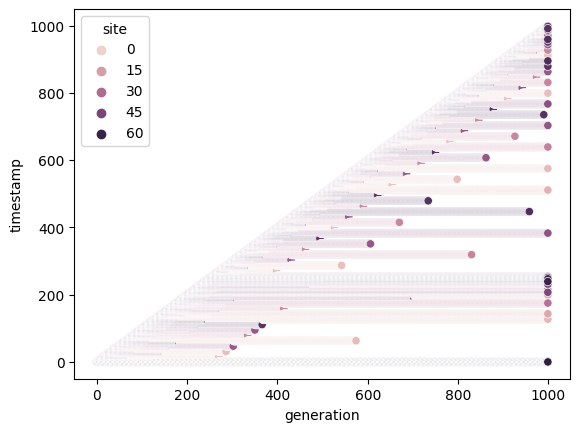

In [21]:
sns.scatterplot(
    data=surface_timestamps_df,
    x="generation",
    y="timestamp",
    hue="site",
)


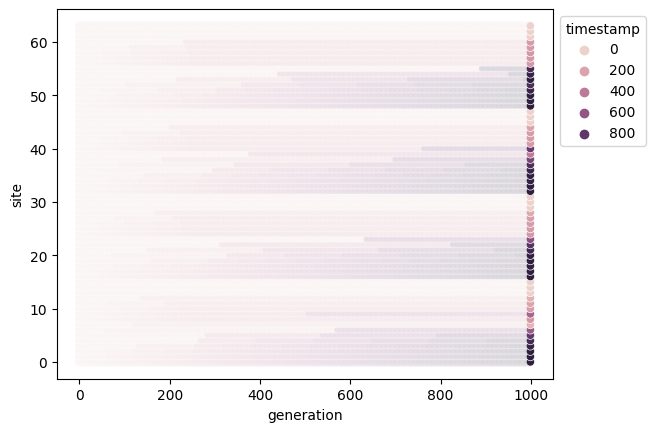

In [22]:
ax = sns.scatterplot(
    data=surface_timestamps_df,
    x="generation",
    y="site",
    hue="timestamp",
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


# 16-bit surface


In [23]:
surface_size = 16
num_generations = 1000

surface_timestamps = [0] * surface_size
surface_values = [random.choice([0, 1]) for __ in range(surface_size)]


In [24]:
surface_timestamps_records = []
for generation in tqdm(range(num_generations)):
    target_site = get_deposition_site_at_rank(generation, surface_size)
    surface_values[target_site] = random.choice([0, 1])
    surface_timestamps[target_site] = generation

    assert [
        get_deposition_rank_at_site(site, surface_size, generation + 1)
        for site in range(surface_size)
    ] == surface_timestamps

    for site, timestamp in enumerate(surface_timestamps):
        surface_timestamps_records.append(
            {
                "generation": generation,
                "site": site,
                "timestamp": timestamp,
            }
        )


100%|██████████| 1000/1000 [00:08<00:00, 124.23it/s]


In [25]:
surface_timestamps_df = pd.DataFrame.from_records(surface_timestamps_records)
surface_timestamps_df


,generation,site,timestamp
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0
...,...,...,...
15995,999,11,247
15996,999,12,239
15997,999,13,223
15998,999,14,191


teeplots/01/hue=site+viz=scatterplot+x=generation+y=timestamp+ext=.pdf
teeplots/01/hue=site+viz=scatterplot+x=generation+y=timestamp+ext=.png


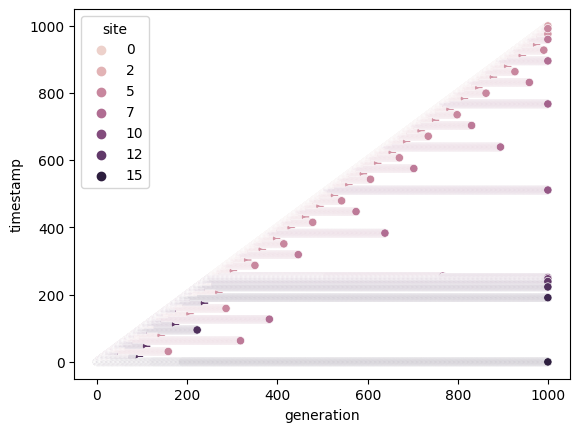

<AxesSubplot: xlabel='generation', ylabel='timestamp'>

In [26]:
pylib.tee_release(
    sns.scatterplot,
    data=surface_timestamps_df,
    x="generation",
    y="timestamp",
    hue="site",
    teeplot_subdir="01",
)


In [27]:
def scatterplot_legout(*args, **kwargs):
    ax = sns.scatterplot(
        *args,
        **kwargs,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


teeplots/01/hue=timestamp+viz=scatterplot-legout+x=generation+y=site+ext=.pdf
teeplots/01/hue=timestamp+viz=scatterplot-legout+x=generation+y=site+ext=.png


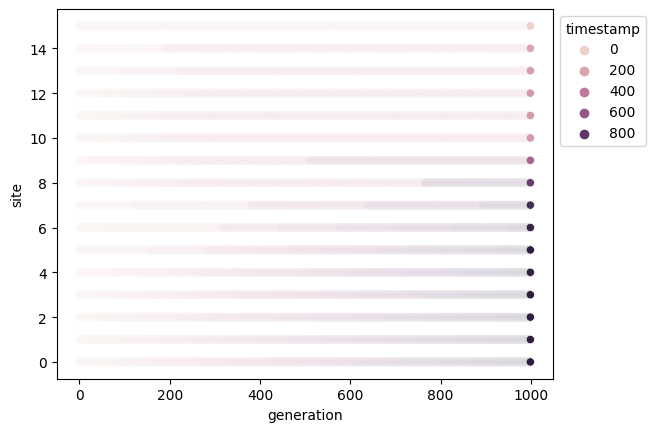

In [28]:
pylib.tee_release(
    scatterplot_legout,
    data=surface_timestamps_df,
    x="generation",
    y="site",
    hue="timestamp",
    teeplot_subdir="01",
)


# Visualize


In [29]:
def get_surface_rank_capacity(surface_size: int) -> int:
    return pylib.hanoi.get_index_of_hanoi_value_nth_incidence(surface_size, 0)


100%|██████████| 127/127 [00:00<00:00, 148047.97it/s]


teeplots/01/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


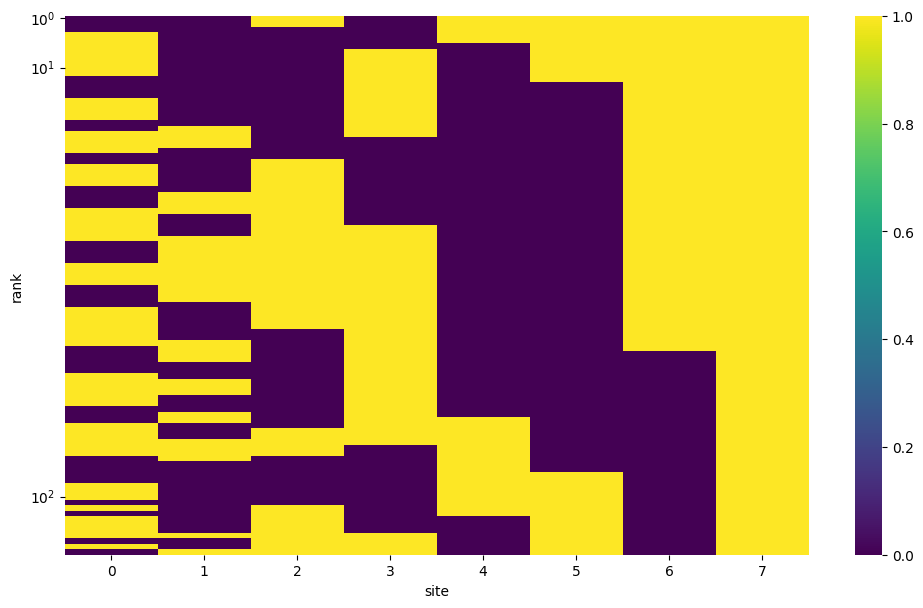

teeplots/01/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


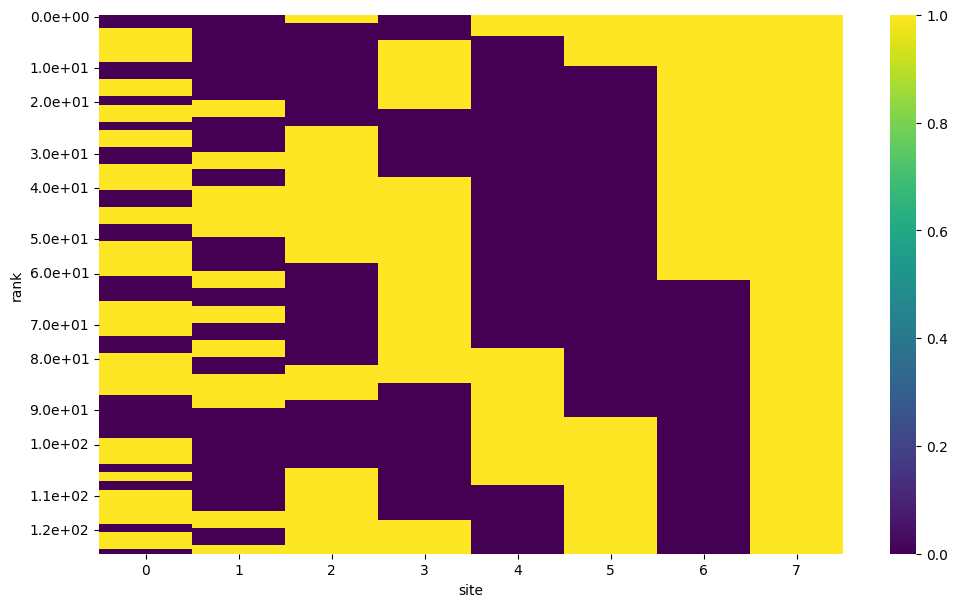

teeplots/01/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


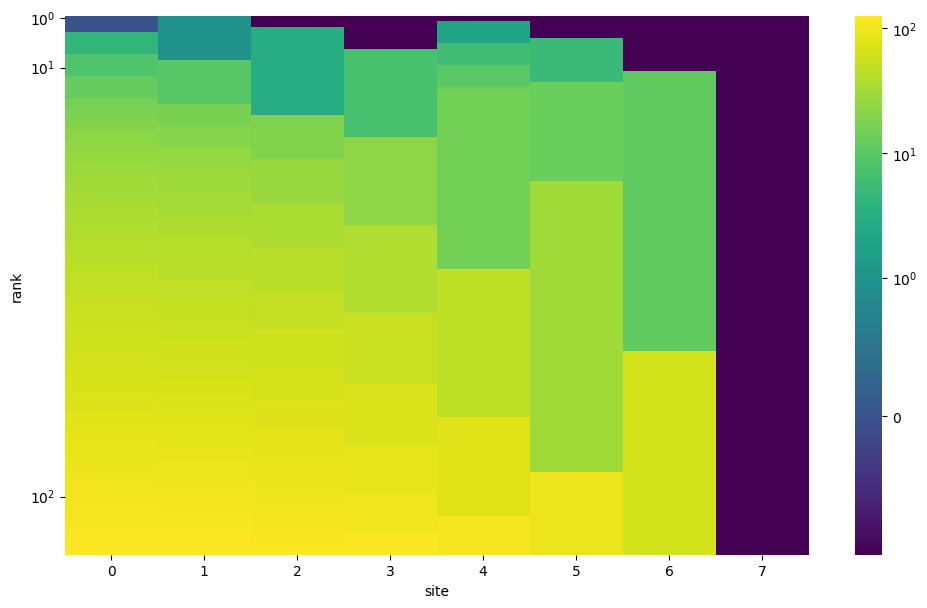

teeplots/01/cnorm=None+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/cnorm=None+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


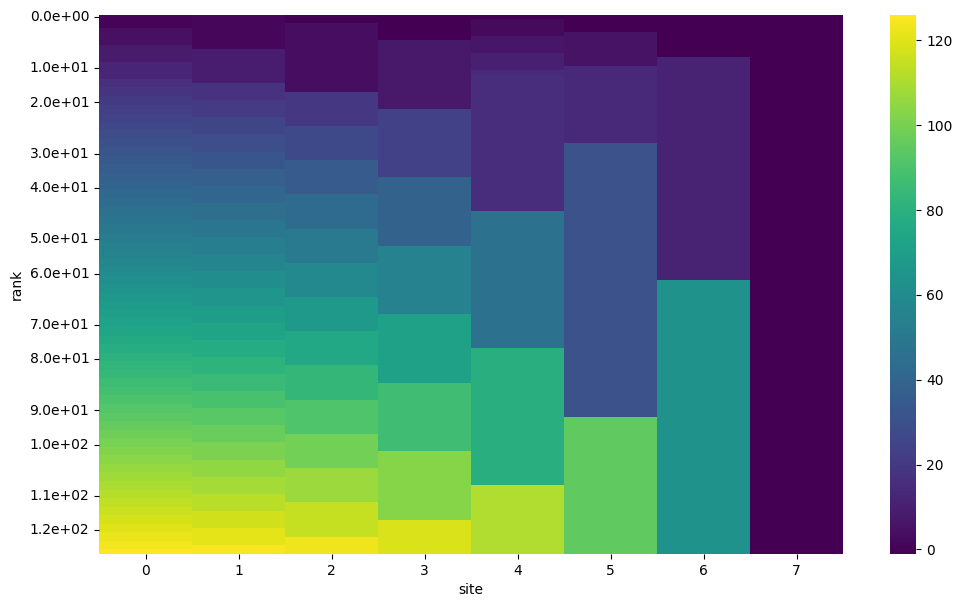

teeplots/01/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/01/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ext=.png


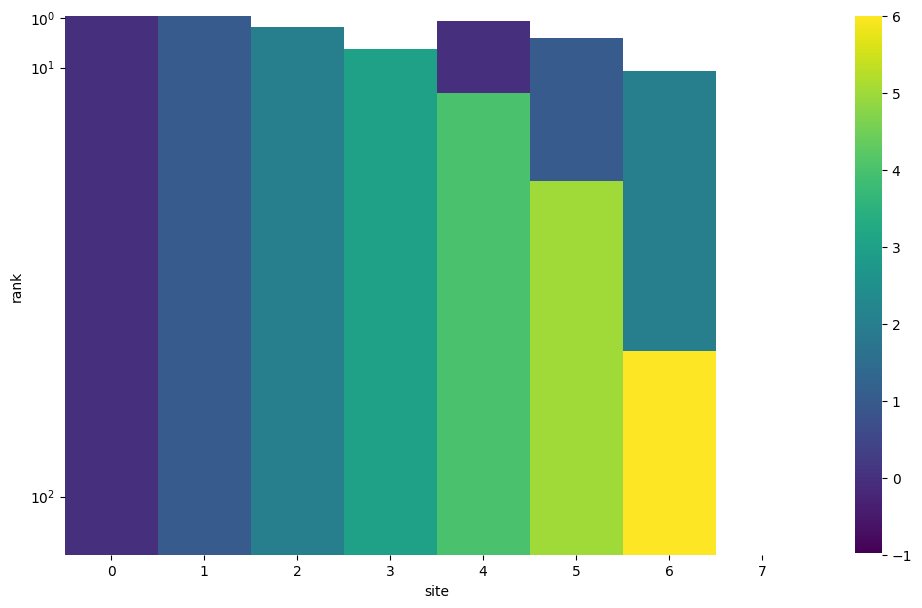

teeplots/01/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


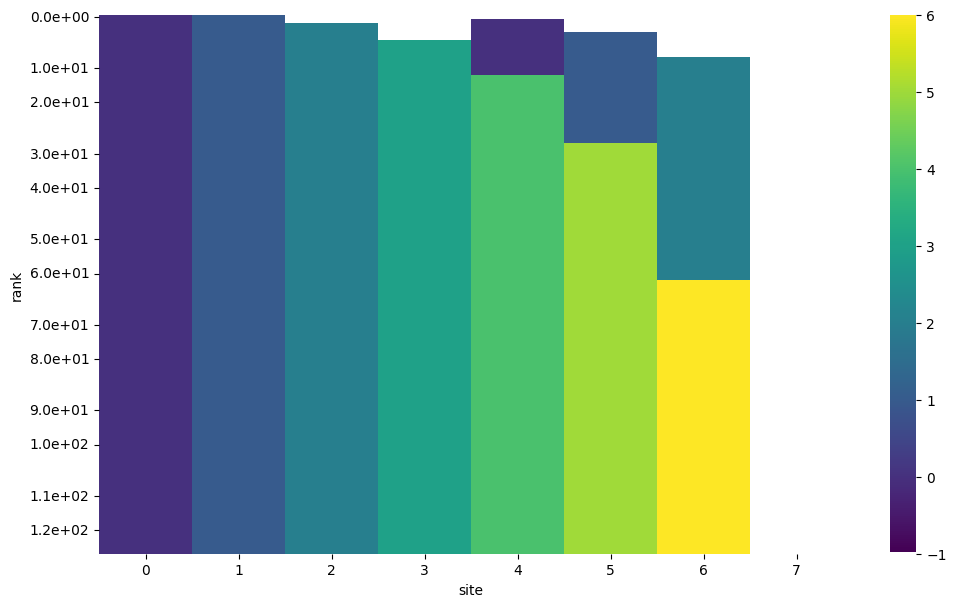

teeplots/01/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


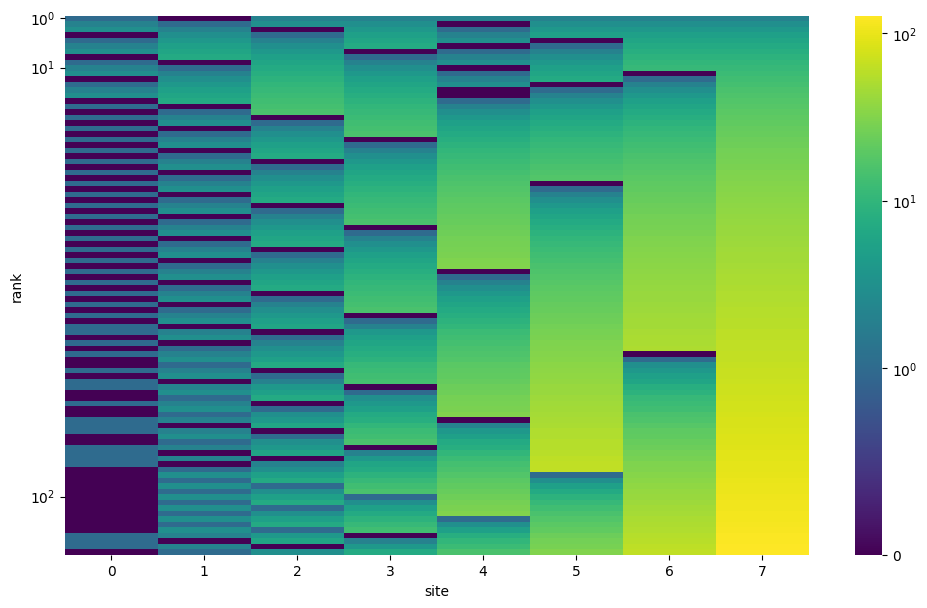

teeplots/01/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


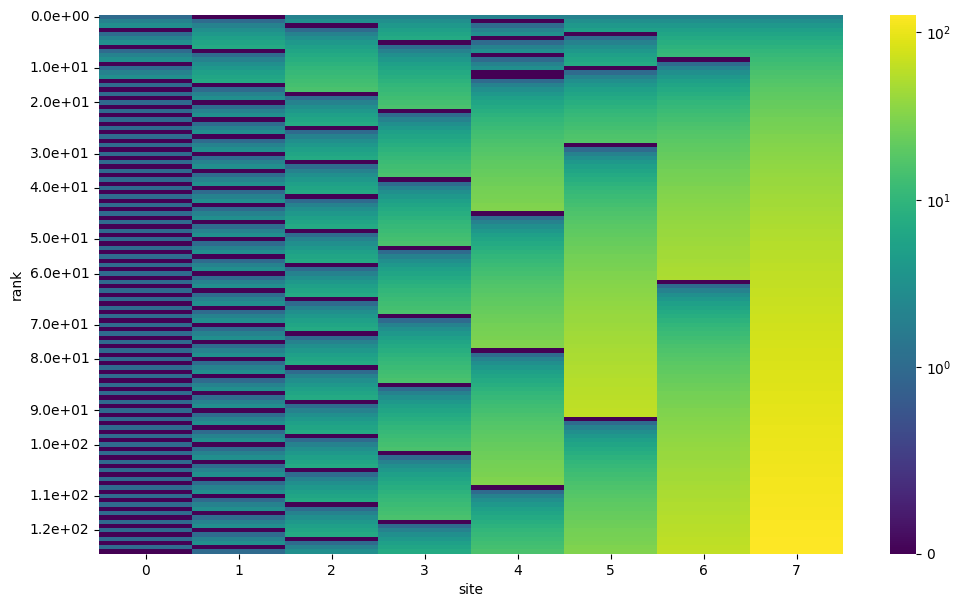

100%|██████████| 125/125 [00:00<00:00, 312.46it/s]


teeplots/01/num-generations=127+surface-size=8+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/01/num-generations=127+surface-size=8+viz=stratum-persistence-dripplot+ext=.png


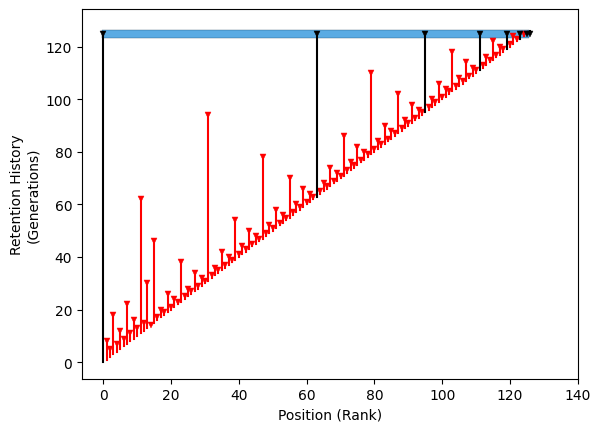

100%|██████████| 262144/262144 [00:04<00:00, 64085.74it/s]


teeplots/01/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


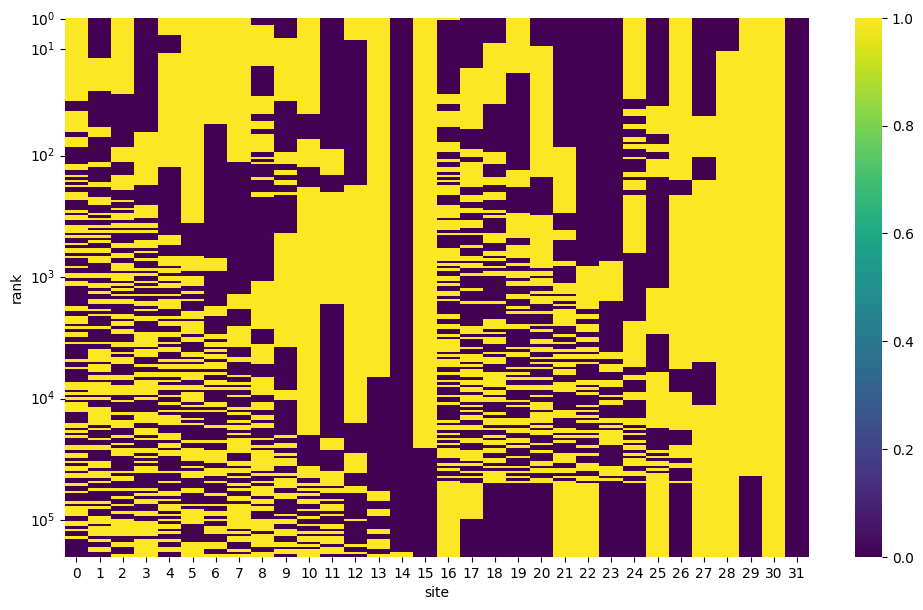

teeplots/01/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


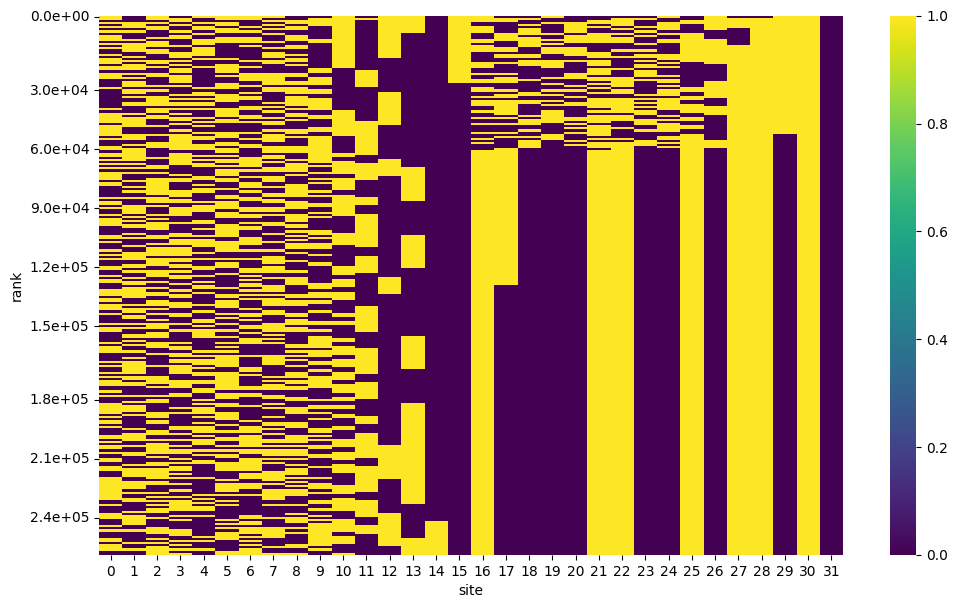

teeplots/01/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


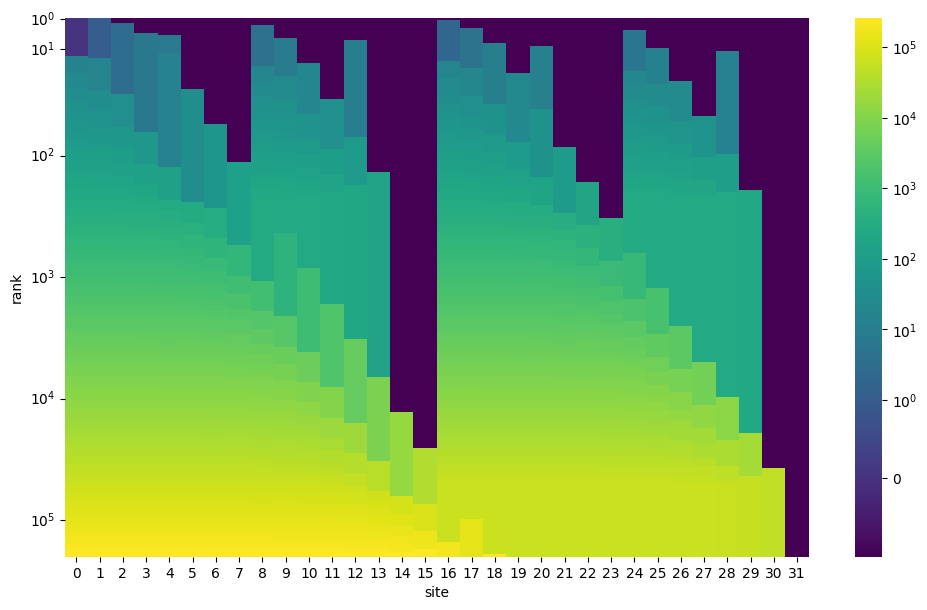

teeplots/01/cnorm=None+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/cnorm=None+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


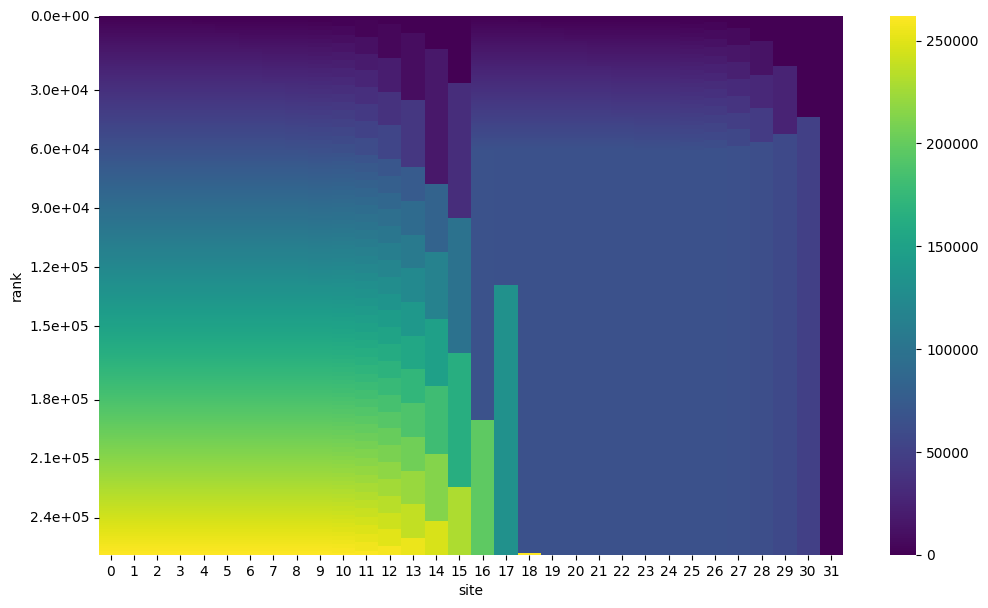

teeplots/01/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/01/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.png


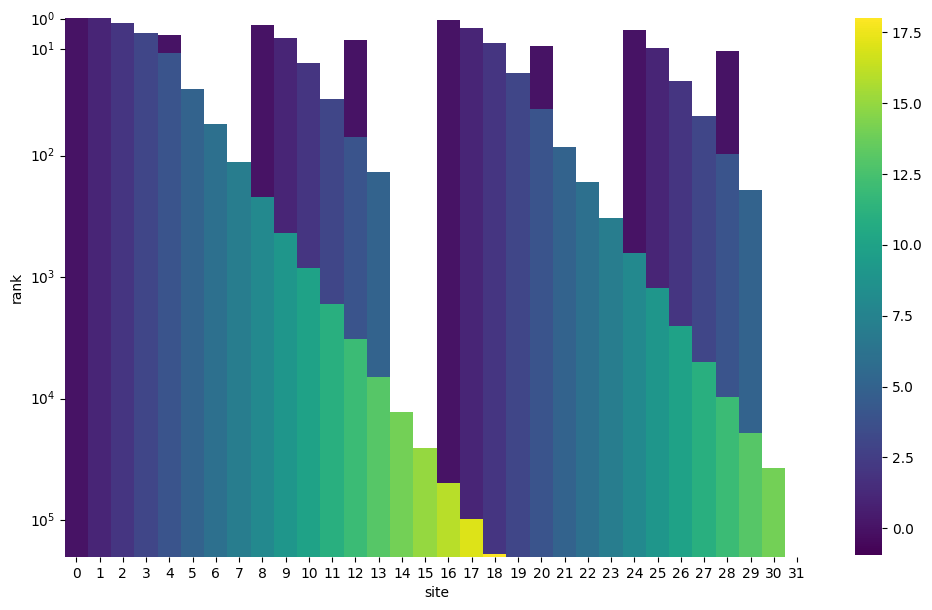

teeplots/01/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


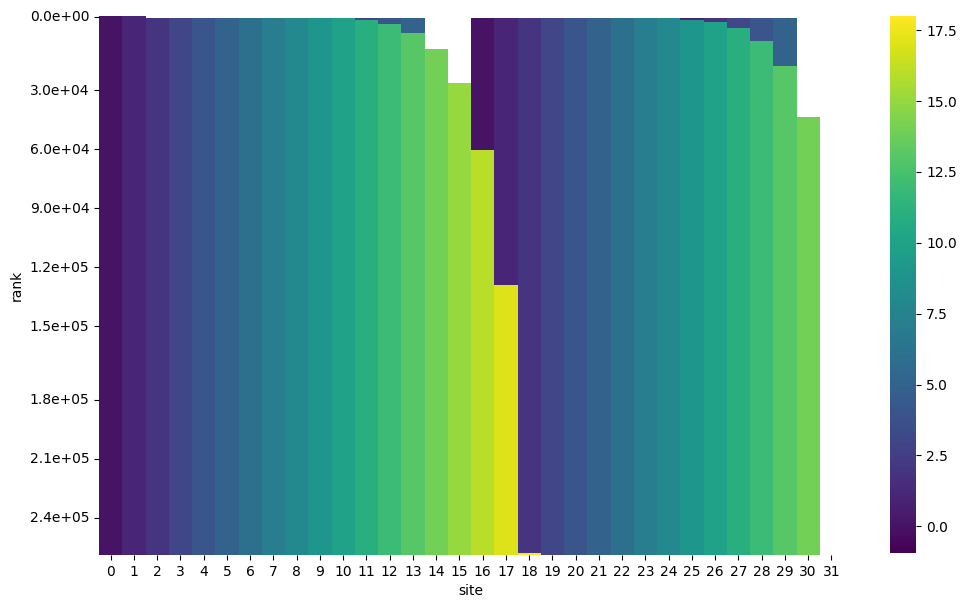

teeplots/01/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


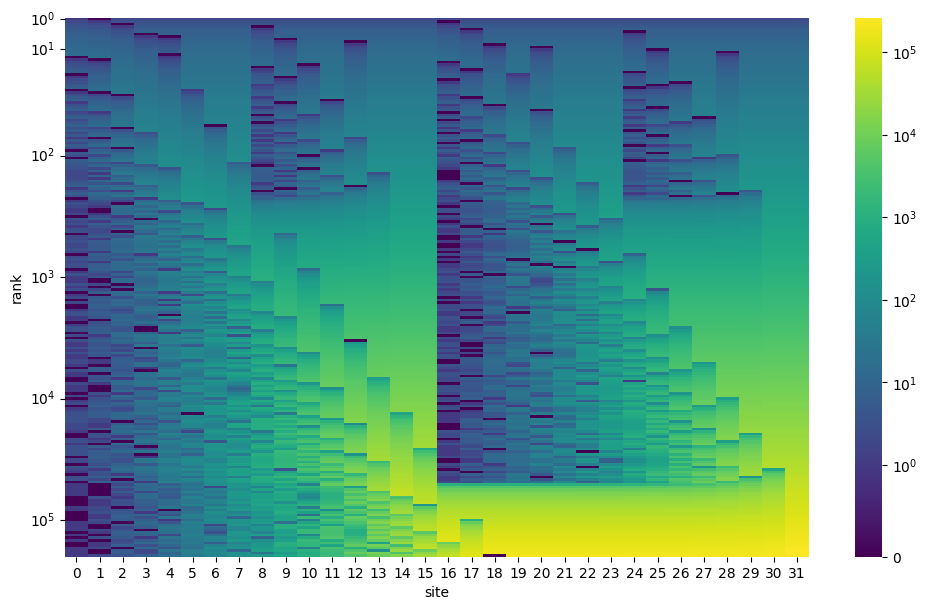

teeplots/01/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


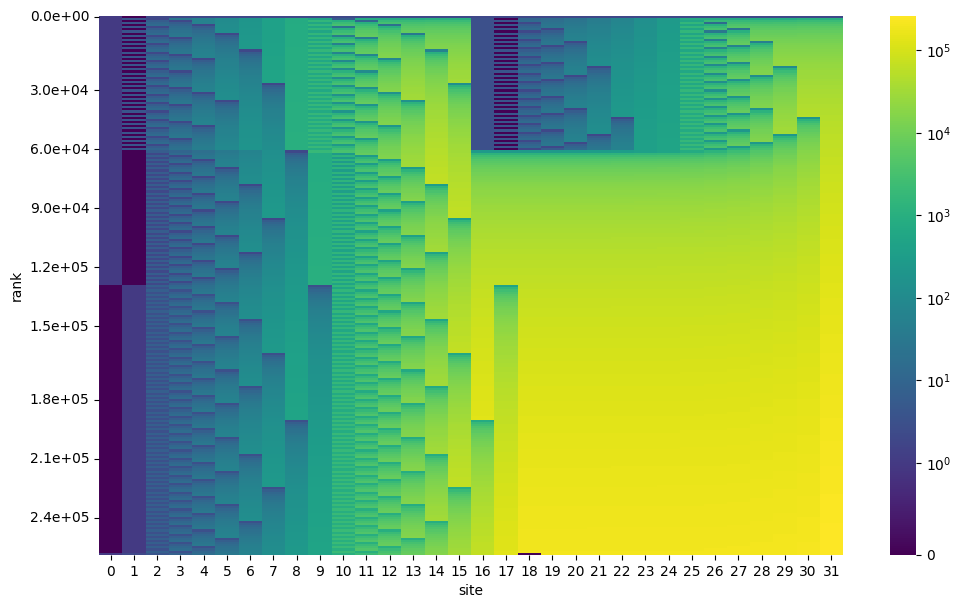

100%|██████████| 2998/2998 [00:08<00:00, 366.53it/s]


teeplots/01/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/01/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.png


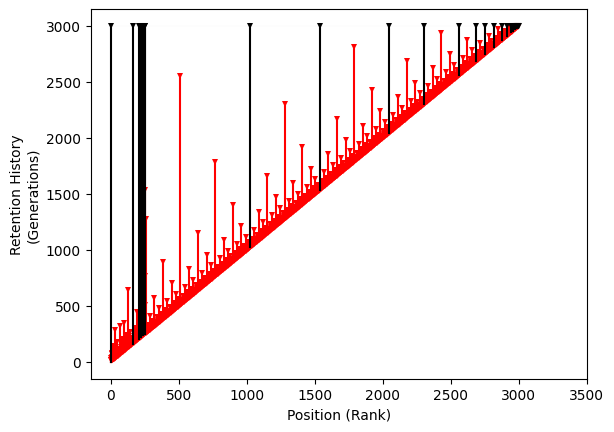

100%|██████████| 4096/4096 [00:00<00:00, 20335.44it/s]


teeplots/01/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


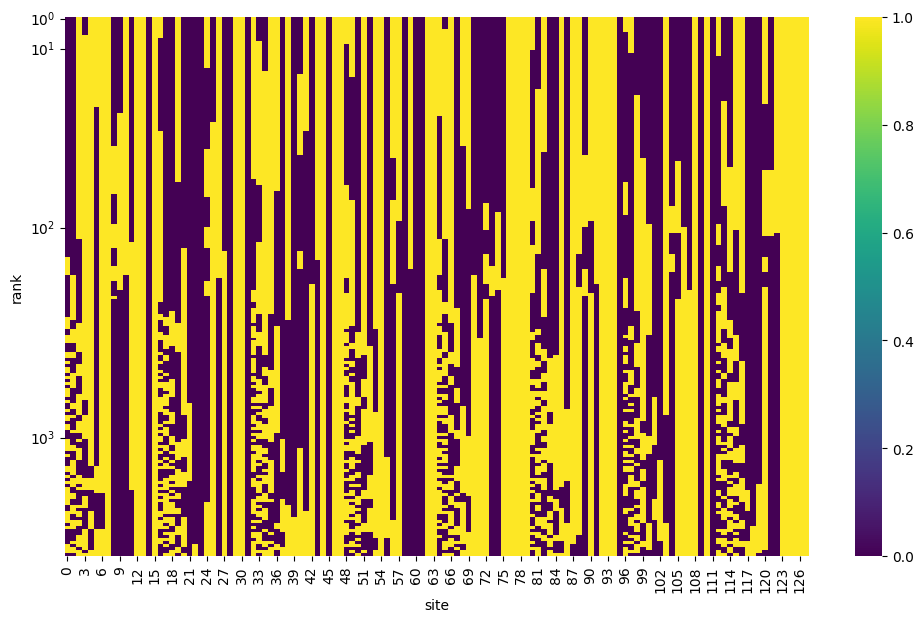

teeplots/01/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


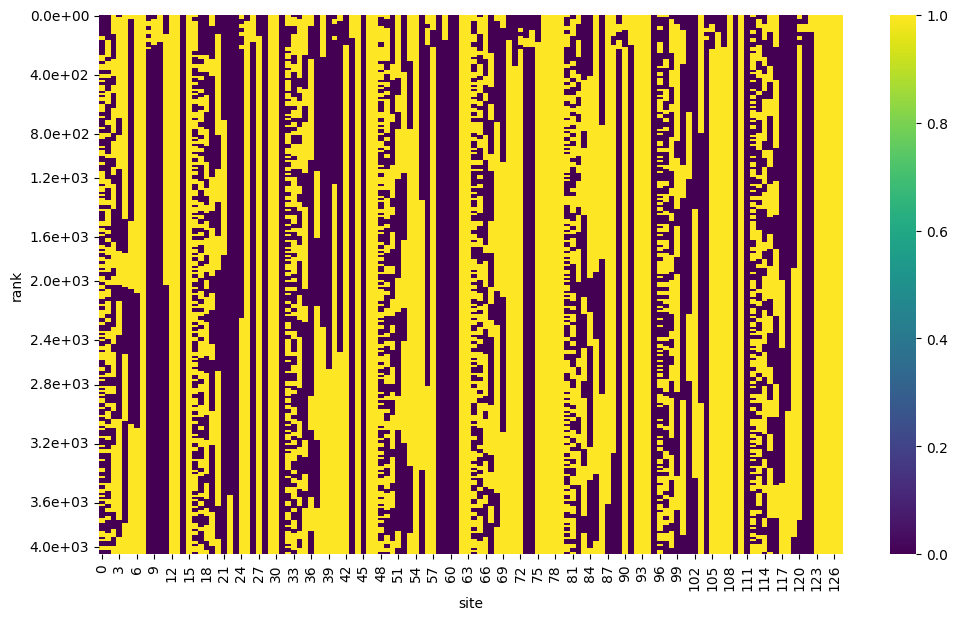

teeplots/01/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


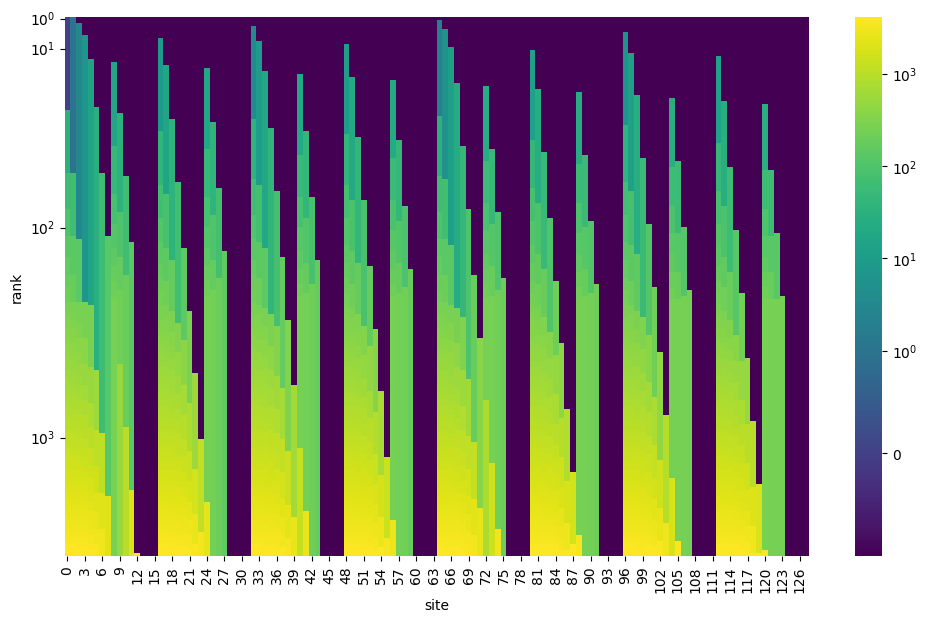

teeplots/01/cnorm=None+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/cnorm=None+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


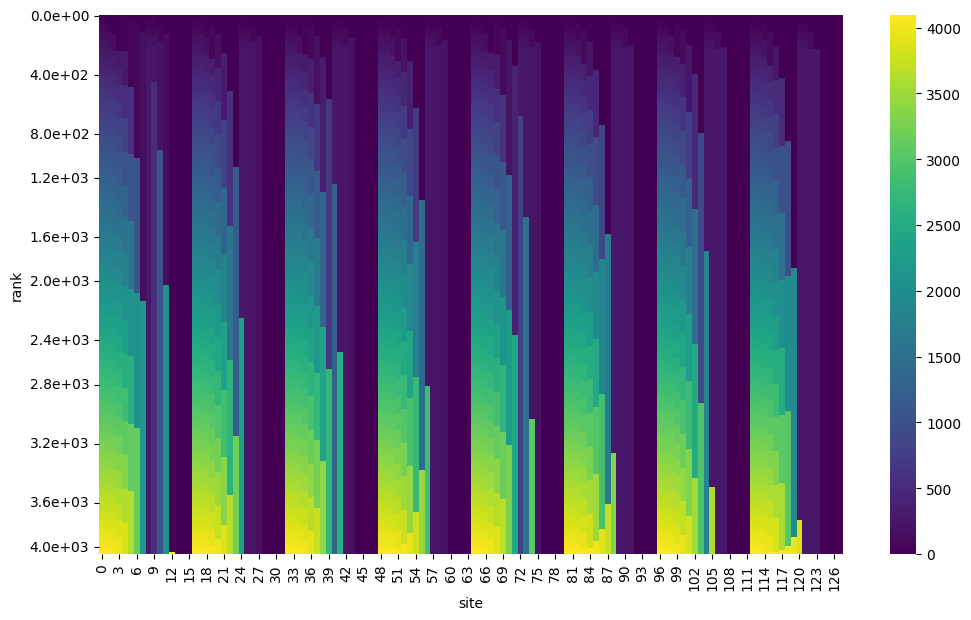

teeplots/01/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/01/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.png


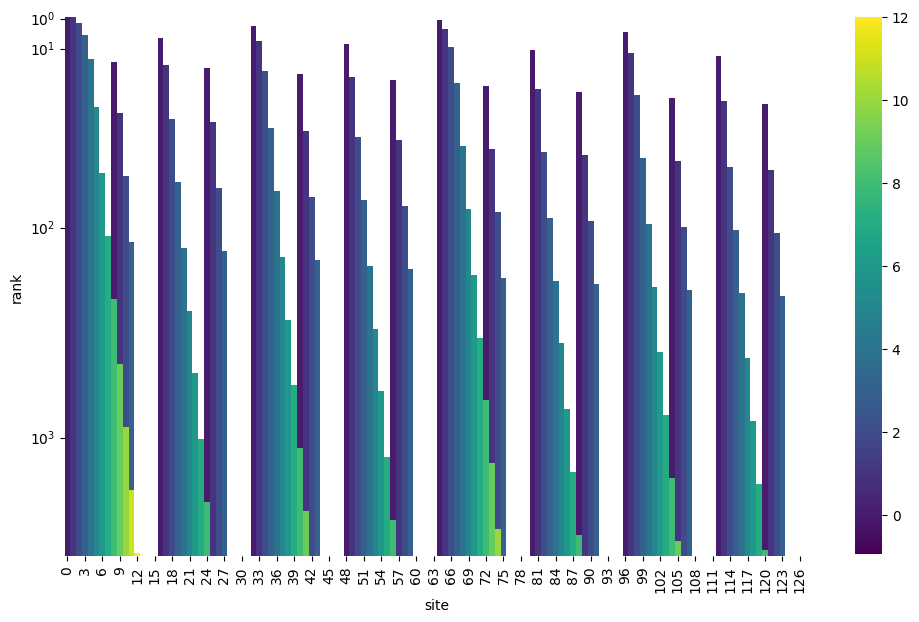

teeplots/01/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


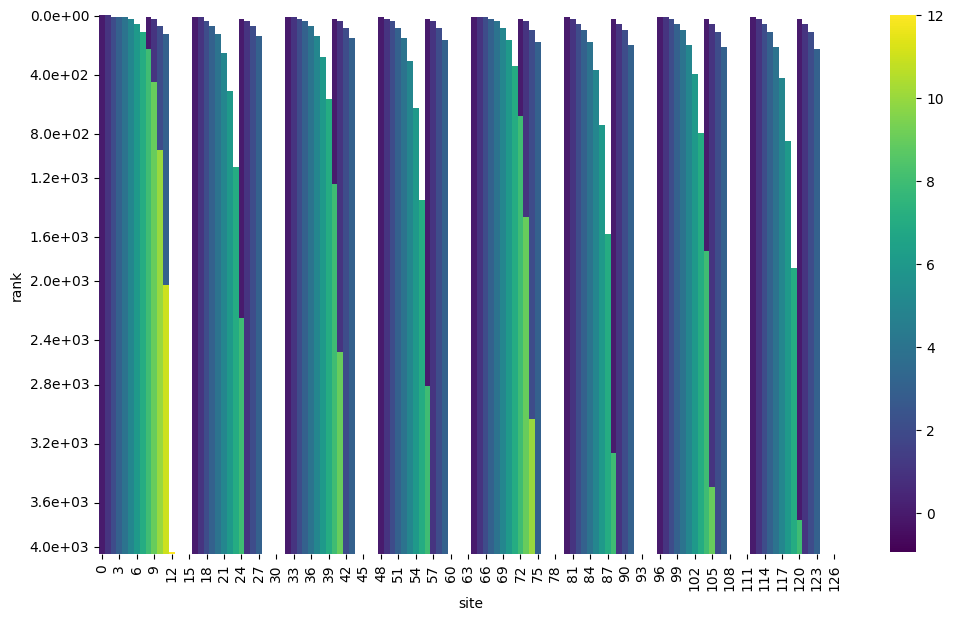

teeplots/01/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


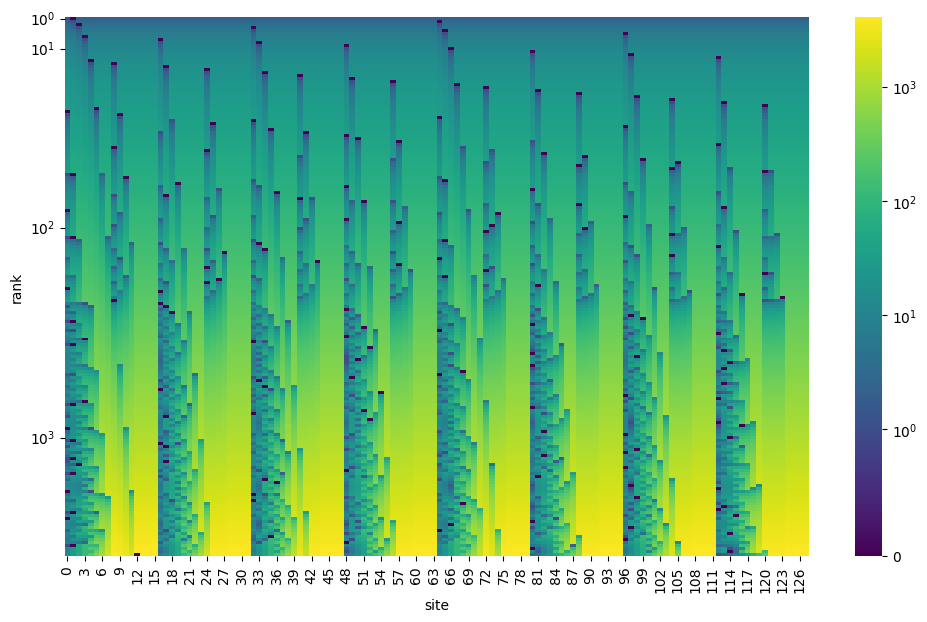

teeplots/01/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


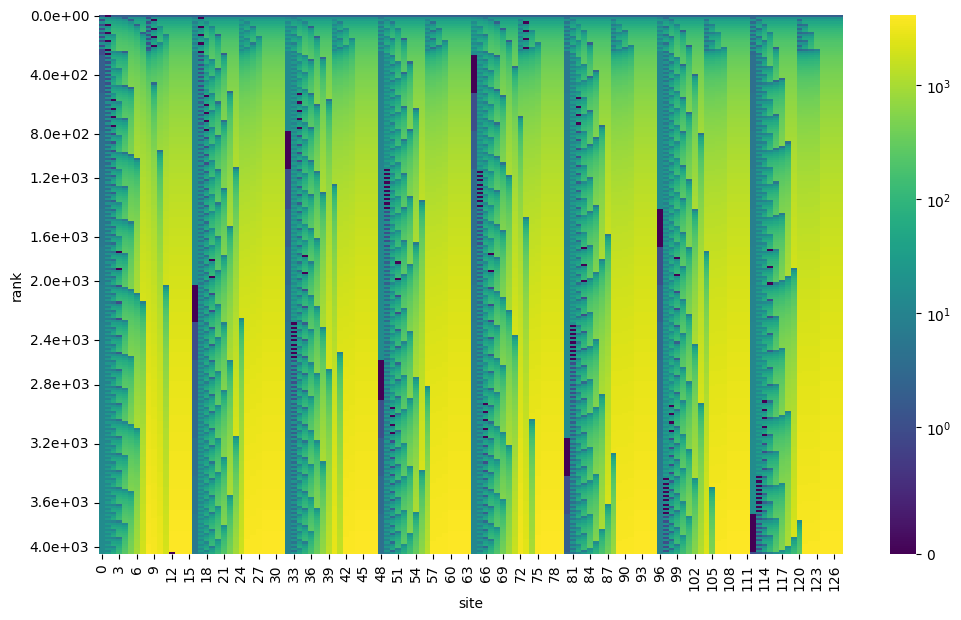

100%|██████████| 2998/2998 [00:10<00:00, 296.94it/s]


teeplots/01/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/01/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.png


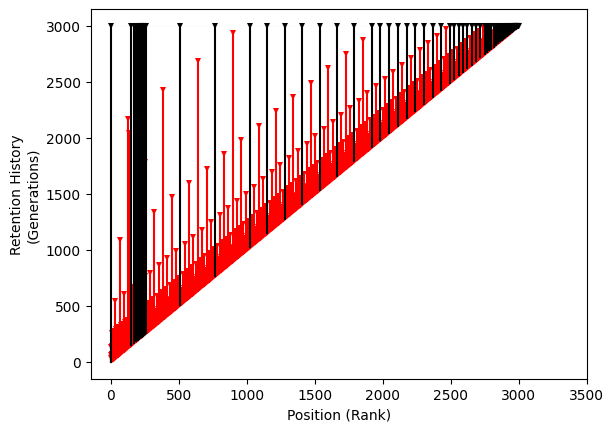

100%|██████████| 4096/4096 [00:00<00:00, 5102.75it/s]


teeplots/01/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


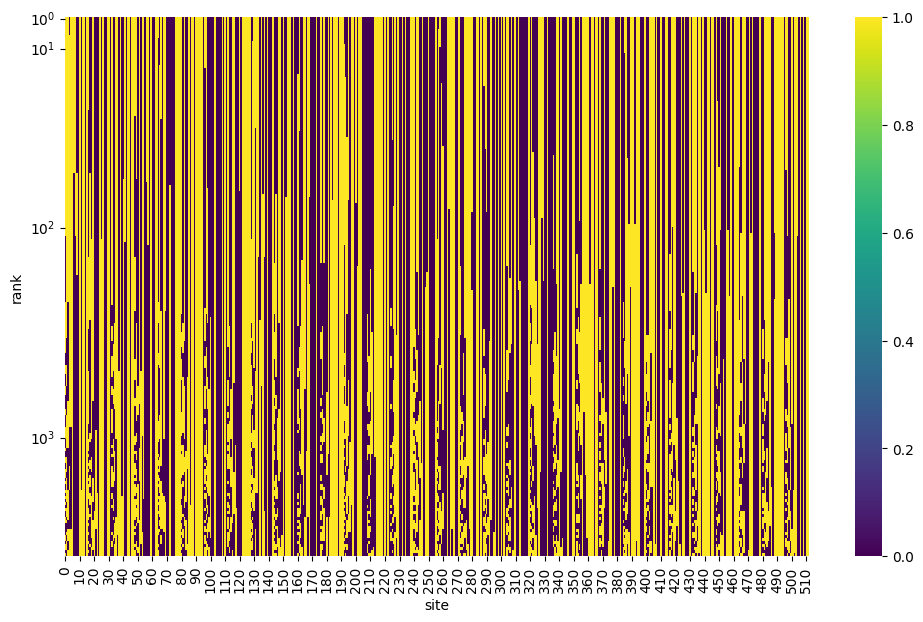

teeplots/01/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


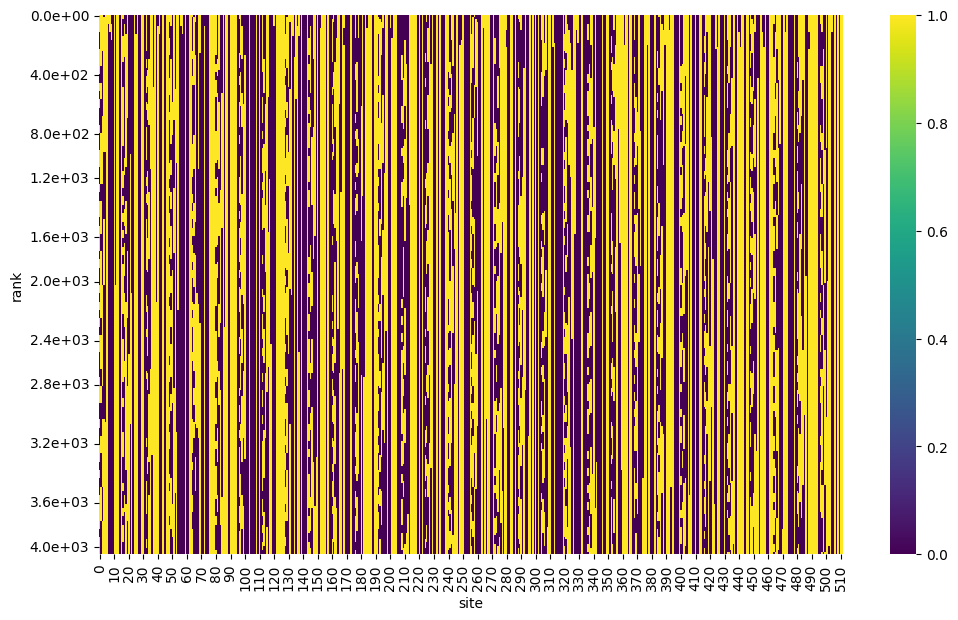

teeplots/01/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


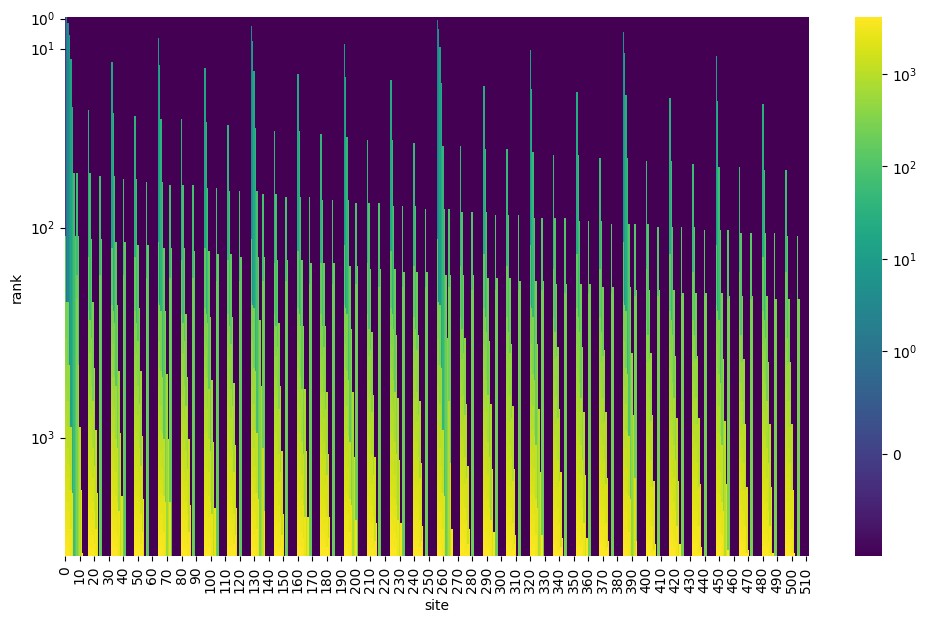

teeplots/01/cnorm=None+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/cnorm=None+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


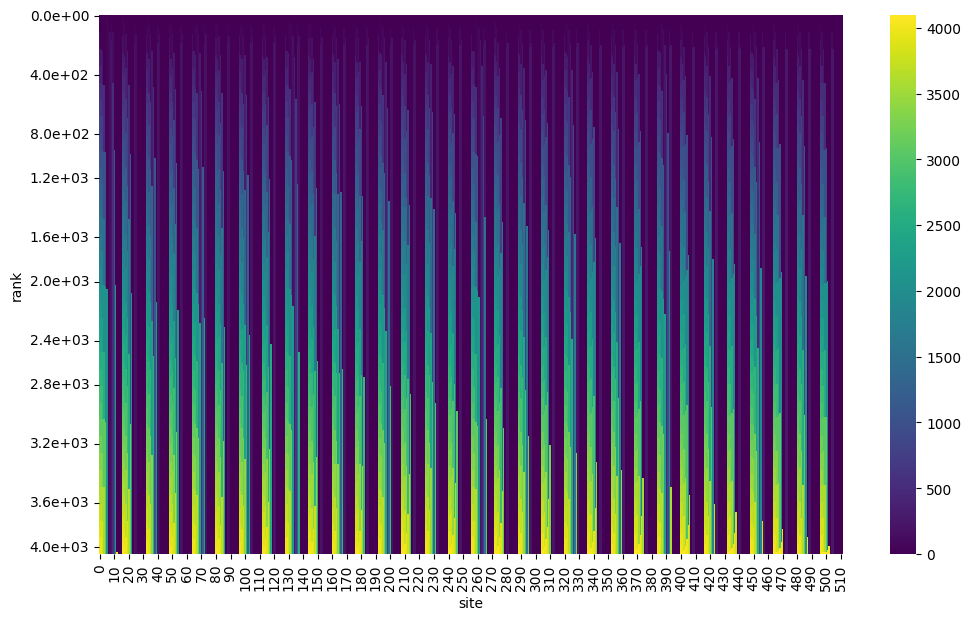

teeplots/01/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/01/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ext=.png


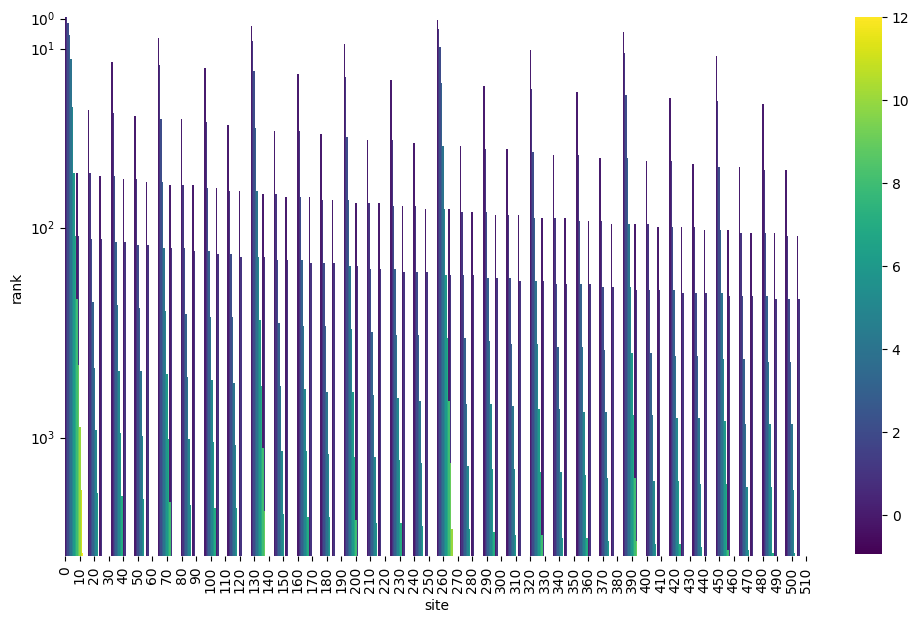

teeplots/01/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


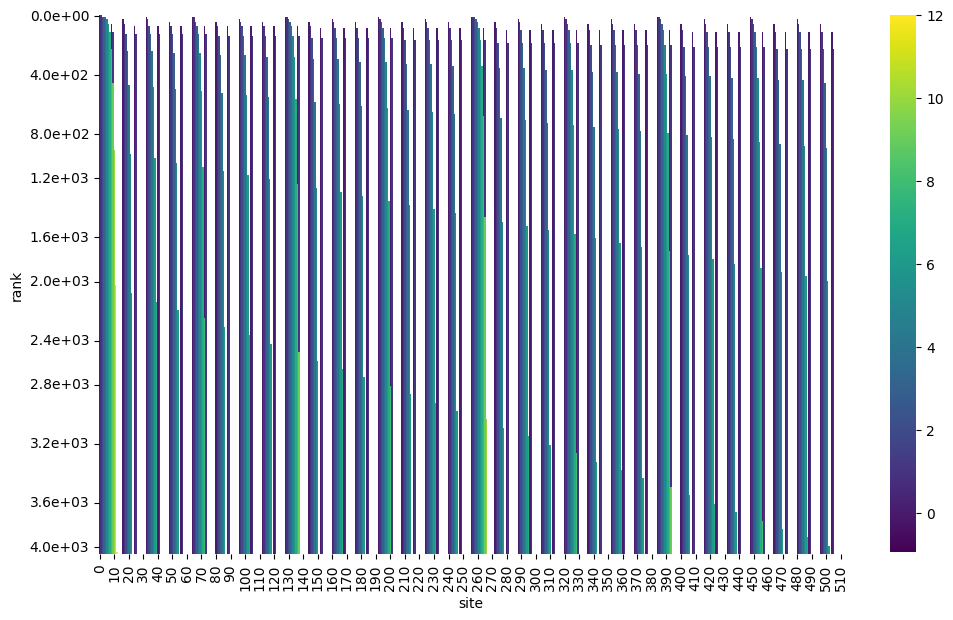

teeplots/01/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/01/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


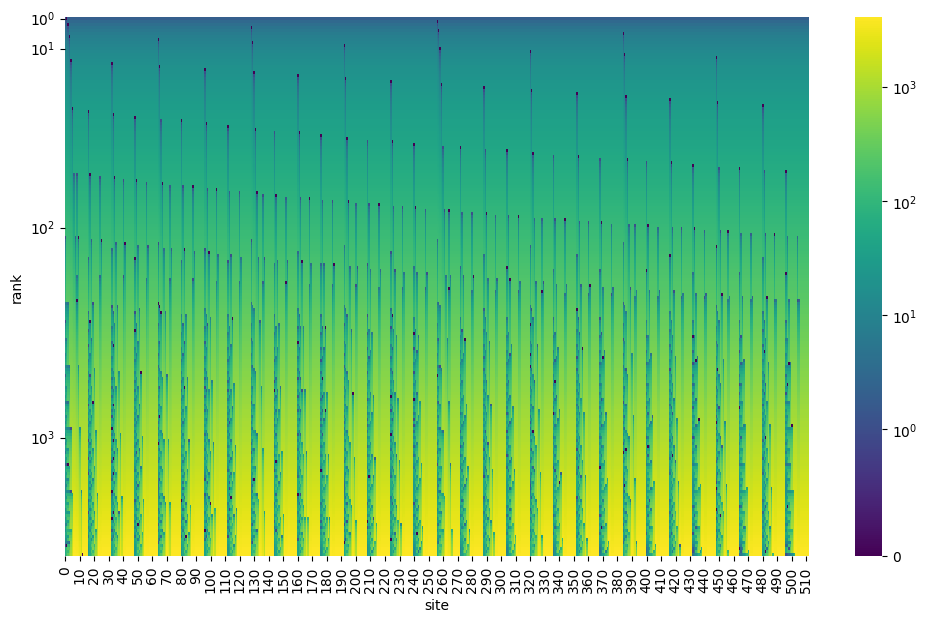

teeplots/01/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/01/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


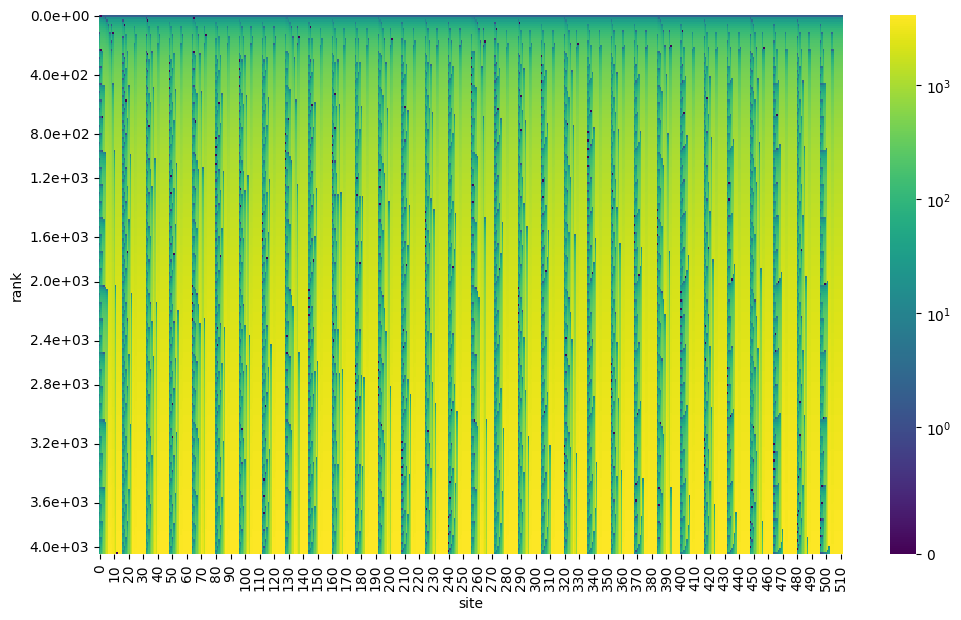

100%|██████████| 2998/2998 [00:14<00:00, 202.18it/s]


teeplots/01/num-generations=4096+surface-size=512+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/01/num-generations=4096+surface-size=512+viz=stratum-persistence-dripplot+ext=.png


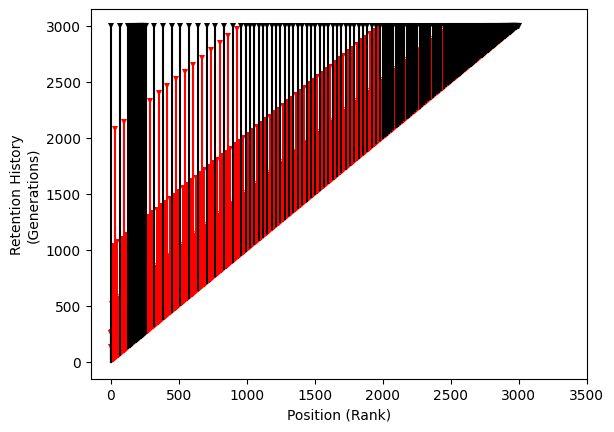

In [30]:
for surface_size_exp in range(3, 10, 2):
    surface_size = 2**surface_size_exp
    display(HTML(f"<h3>surface size {surface_size}</h3>"))

    num_generations = min(
        # don't run out of memory
        2**18 if surface_size_exp < 7 else 2**12,
        get_surface_rank_capacity(surface_size - 1),
    )

    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        get_deposition_site_at_rank,
        surface_size=surface_size,
        num_generations=num_generations,
        progress_wrap=tqdm,
    )

    # ========================
    kwargs = dict(
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="01",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="01",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="01",
    )

    # ========================
    kwargs = dict(
        cnorm=None,
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="01",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="01",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="01",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="01",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="01",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.stratum_persistence_dripplot,
        surface_history_df[surface_history_df["rank"] < 3000],
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        progress_wrap=tqdm,
        teeplot_subdir="01",
    )
